# GB1 analysis 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import evoVAE.utils.seq_tools as st
import numpy as np
import logomaker as lm
import evoVAE.utils.statistics as stats
from matplotlib.patches import Patch
from scipy.stats import wasserstein_distance

%matplotlib inline

In [144]:
def plot_entropy(ancestors, extants, anc_count, ext_count, mutations, protein, title, ax, start=0, end=None):
    
    e_col_entropy = stats.calc_shannon_entropy(extants) 
    a_col_entropy = stats.calc_shannon_entropy(ancestors)

    if end is not None: 
        # across entire sequnece 
        xticks = range(start, end)
        e_col_entropy = e_col_entropy[start:end]
        a_col_entropy = a_col_entropy[start:end]
  
    else: 
        xticks = range(start, len(a_col_entropy))
   
    fig = plt.figure(figsize=(12, 8))
    ax.plot(xticks, a_col_entropy, alpha=1,  color='orange')
    ax.plot(xticks, e_col_entropy, alpha=1, color='blue')
    ax.set_xlabel("Sequence position")
    ax.set_ylabel("Entropy")
    ax.set_ylim(0, 2.6)


    legend_elements = [
        Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
        Patch(facecolor='orange', edgecolor='black',label=f"{protein} ancestors ({anc_count} seqs)"),
        Patch(facecolor='blue', edgecolor='black', label=f"{protein} extants ({ext_count} seqs)"),
    ]

    ax.legend(handles=legend_elements,)
    if end is not None:
        ax.set_xticks(xticks, labels=xticks)

    for mutation in mutations:
        ax.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

    ax.set_title(f"{protein}: {title}")
    #plt.show()

def calc_column_wasserstein_distances(ancestors, extants, ancestors_extants, variants):
    """
    Returns:
    wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v
    """
    
    if ancestors.split(".")[-1] in ["fasta", "aln"]:
        a = st.read_aln_file(ancestors)
    else: 
        a = pd.read_pickle(ancestors)
    
    
    if ancestors_extants.split(".")[-1] in ["fasta", "aln"]:
        ae = st.read_aln_file(ancestors_extants)
    else: 
        ae = pd.read_pickle(ancestors_extants)
    
        
    if extants.split(".")[-1] in ["fasta", "aln"]:
        e = st.read_aln_file(extants)
    else: 
        e = pd.read_pickle(extants)    

    var = pd.read_csv(variants)
    var = var.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

    a_ppm = stats.calc_position_prob_matrix(a)
    e_ppm = stats.calc_position_prob_matrix(e)
    ae_ppm = stats.calc_position_prob_matrix(ae)
    var_ppm = stats.calc_position_prob_matrix(var)

    wd_a_to_e = []
    wd_a_to_ae = []
    wd_e_to_ae = []
    wd_a_to_v = []
    wd_e_to_v = []
    wd_ae_to_v = []

    for i in range(a_ppm.shape[1]):
        col_a_i = a_ppm[:, i]
        col_e_i = e_ppm[:, i]
        col_ae_i = ae_ppm[:, i]
        col_v_i = var_ppm[:, i]
        
        wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
        wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
        wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

        wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
        wd_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
        wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

    return wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_e_to_v, wd_ae_to_v
    
    
    

In [ ]:
meta = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_substitutions.csv")
#print(meta.columns)
meta[meta["DMS_id"] == "SPG1_STRSG_Wu_2016"]["target_seq"].values[0]

The following residues were modified

They all lie within 15 residues of each other 

The distribution of data is very skewed though
"While most mutants had a lower fitness compared to WT (fitness < 1), 2.4% of mutants were beneficial (fitness > 1)."

### GB1 - variant distribution 

In [6]:
gb1_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
gb1_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D266A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.401243,1
1,D266A:G267A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.259549,1
2,D266A:G267A:V280A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,6.201135,1
3,D266A:G267A:V280C,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.705083,1
4,D266A:G267A:V280E,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.004726,0


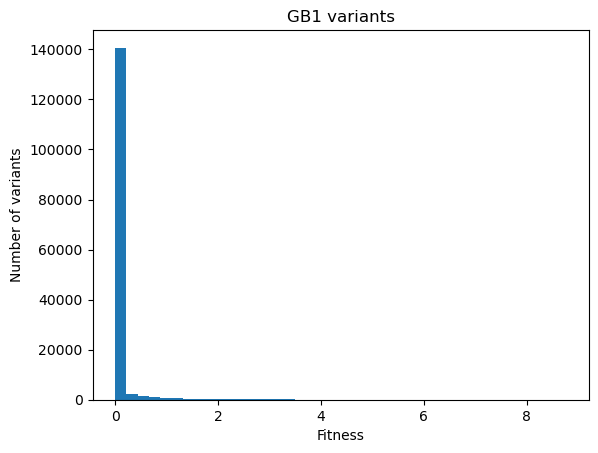

In [6]:
gb1_variants["DMS_score"].describe()

plt.hist(gb1_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GB1 variants")
plt.show()

### GB1 - entropy 

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 455
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)


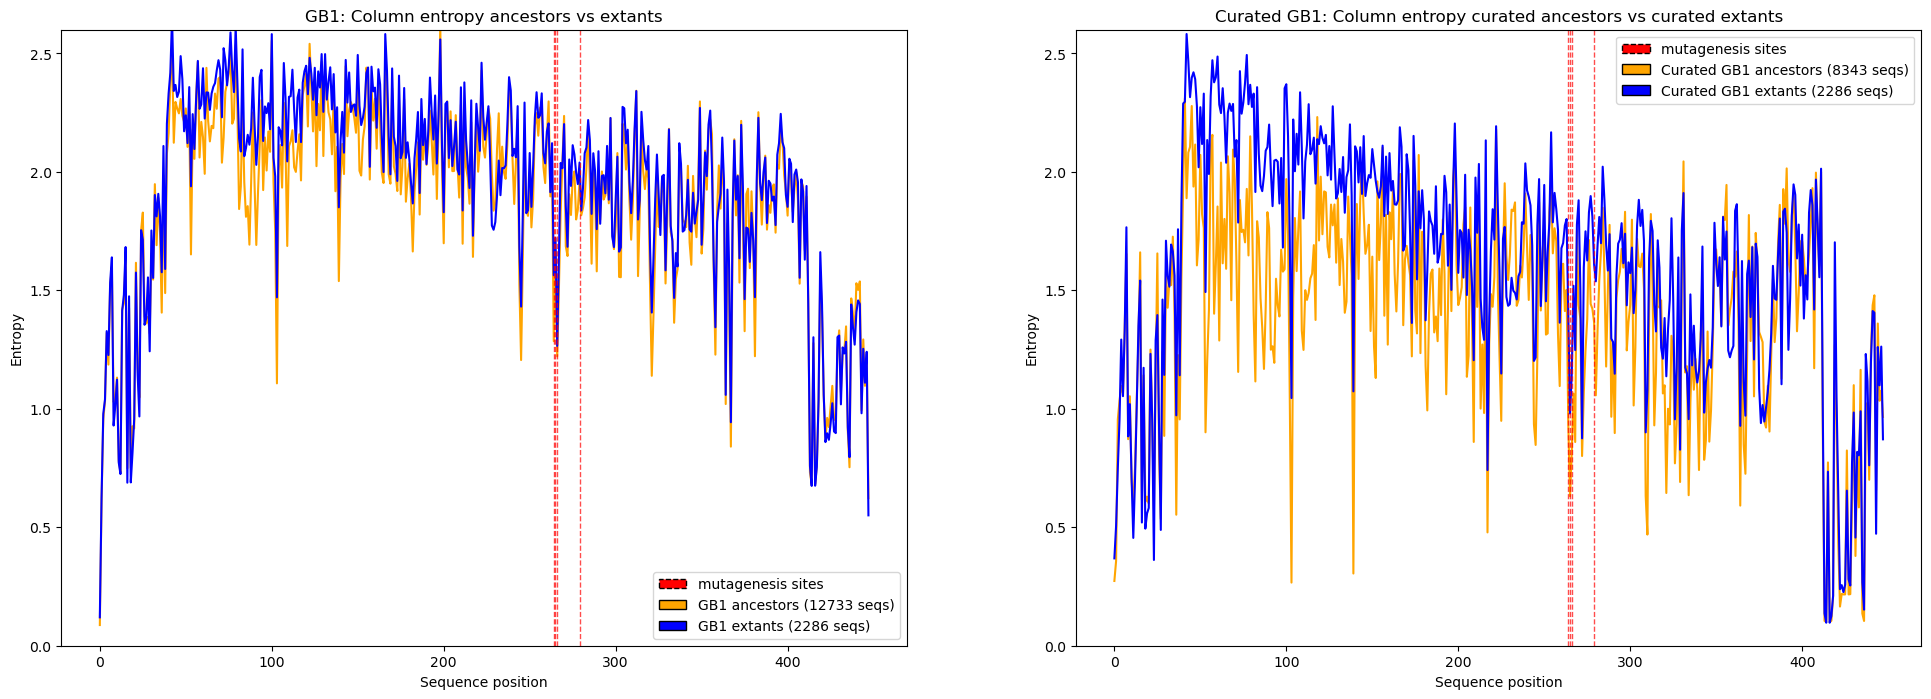

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)


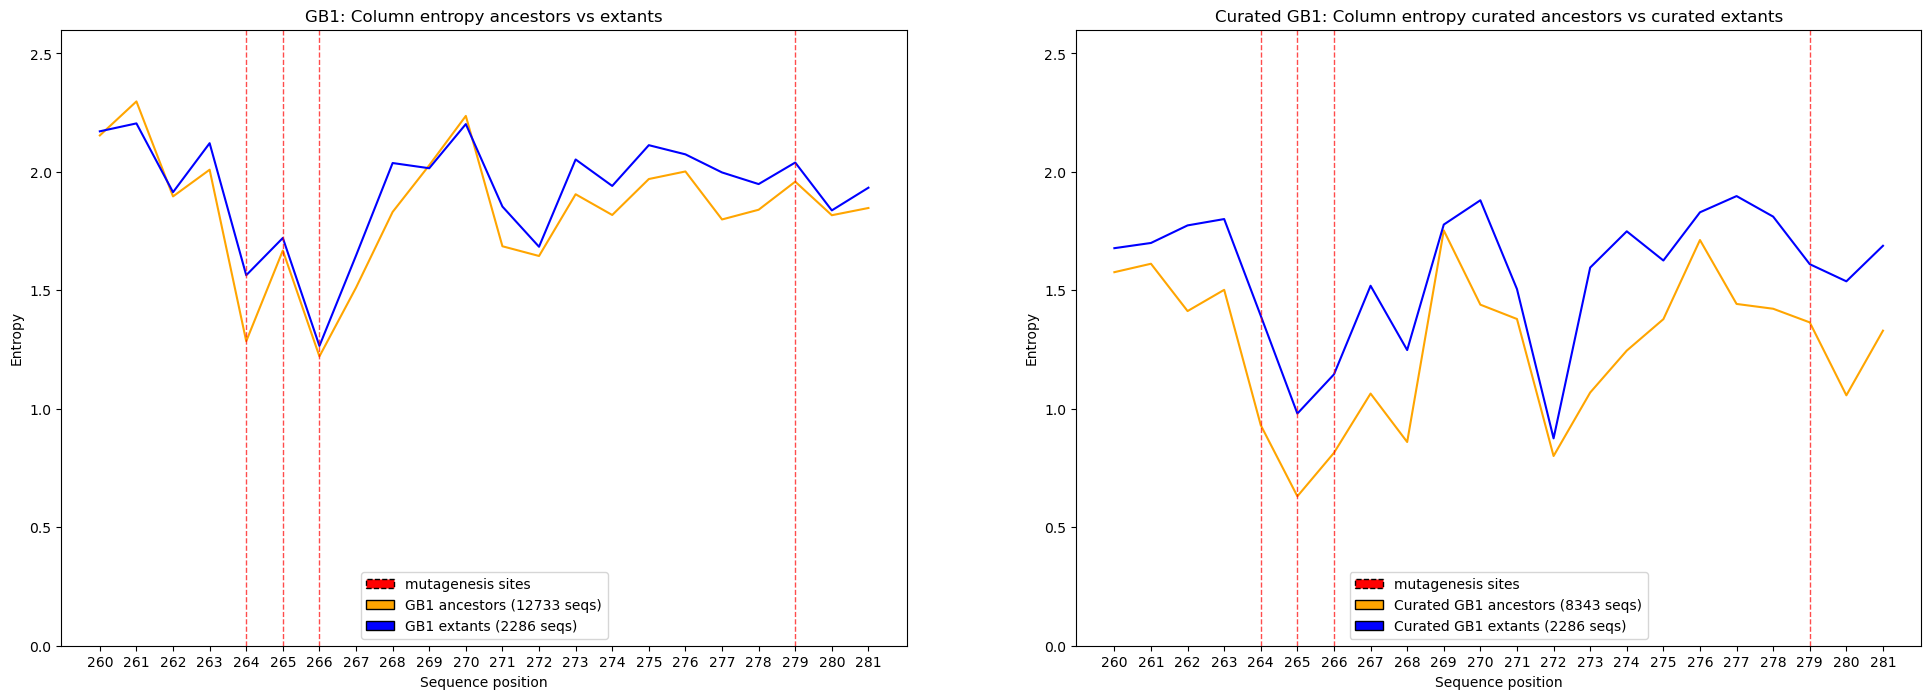

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [145]:
################ UNCURATED ##############

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_e = pd.read_pickle(aln_path + "gb1_extants_no_dupes.pkl")
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")



################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
curated_gb1_e = st.read_aln_file(aln_path + "gb1_0.32_sim_extants_no_dupes.aln")
curated_gb1_a = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_no_dupes.aln")



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

plot_entropy(ancestors=gb1_a, extants=gb1_e, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="Column entropy ancestors vs extants", ax=ax1)

plot_entropy(ancestors=curated_gb1_a, extants=curated_gb1_e, anc_count=8343, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="Curated GB1", 
             title="Column entropy curated ancestors vs curated extants", ax=ax2)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# do across a smaller range 
plot_entropy(ancestors=gb1_a, extants=gb1_e, anc_count=12733, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="GB1", 
             title="Column entropy ancestors vs extants", start=260, end=282, ax=ax1)


plot_entropy(ancestors=curated_gb1_a, extants=curated_gb1_e, anc_count=8343, 
             ext_count=2286, mutations = [264, 265, 266, 279], protein="Curated GB1", 
             title="Column entropy curated ancestors vs curated extants", start=260, end=282, ax=ax2)

plt.show()

#### GB1 - Wasserstein distance 

Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (149360, 448)
Dist A-E: 0.5723476482787782
Dist A-AE: 0.06189802838018126
Dist E-AE: 0.5154249919472801
Dist A-V: 5.289377921863789
Dist E-V: 5.457538960734717
Dist AE-V: 5.309562562929609
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8655
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profi

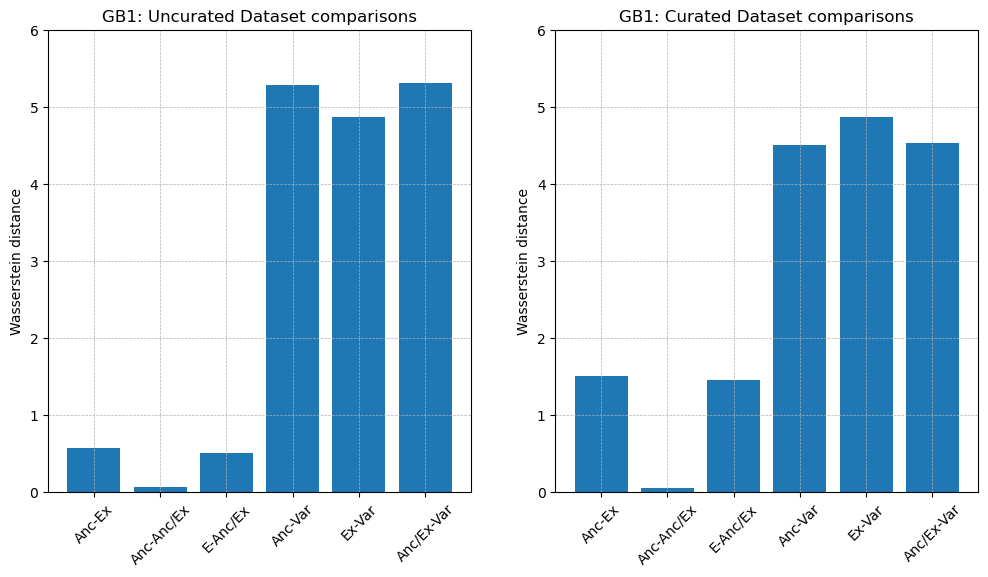

In [148]:


################ UNCURATED ##############
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_curated_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gb1_ancestors_no_dupes.pkl",
    extants= path + "gb1_extants_no_dupes.pkl",
    ancestors_extants= path + "gb1_ancestors_extants_no_dupes.pkl",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")




################### CURATED ANCESTORS & EXTANTS ##################

path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
wd_curated_a_to_curated_e, wd_curated_a_to_curated_ae, wd_curated_e_to_curated_ae, wd_curated_a_to_v, wd_curated_e_to_v, wd_curated_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gb1_0.32_sim_ancestors_no_dupes.aln",
    extants= path + "gb1_0.32_sim_extants_no_dupes.aln",
    ancestors_extants= path + "gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")

print(f"Dist curated A-E: {np.mean(wd_curated_a_to_curated_e)}")
print(f"Dist curated A-AE: {np.mean(wd_curated_a_to_curated_ae)}")
print(f"Dist curated E-AE: {np.mean(wd_curated_e_to_curated_ae)}") 

print(f"Dist curated A-V: {np.mean(wd_curated_a_to_v)}")
print(f"Dist curated E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist curated AE-V: {np.mean(wd_curated_ae_to_v)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("GB1: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,6)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


ax2.bar(np.arange(6), [np.mean(wd_curated_a_to_curated_e), np.mean(wd_curated_a_to_curated_ae), np.mean(wd_curated_e_to_curated_ae), np.mean(wd_curated_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_curated_ae_to_v)])
ax2.set_title("GB1: Curated Dataset comparisons")
ax2.set_ylabel("Wasserstein distance")
ax2.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax2.set_ylim(0,6)
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.show()


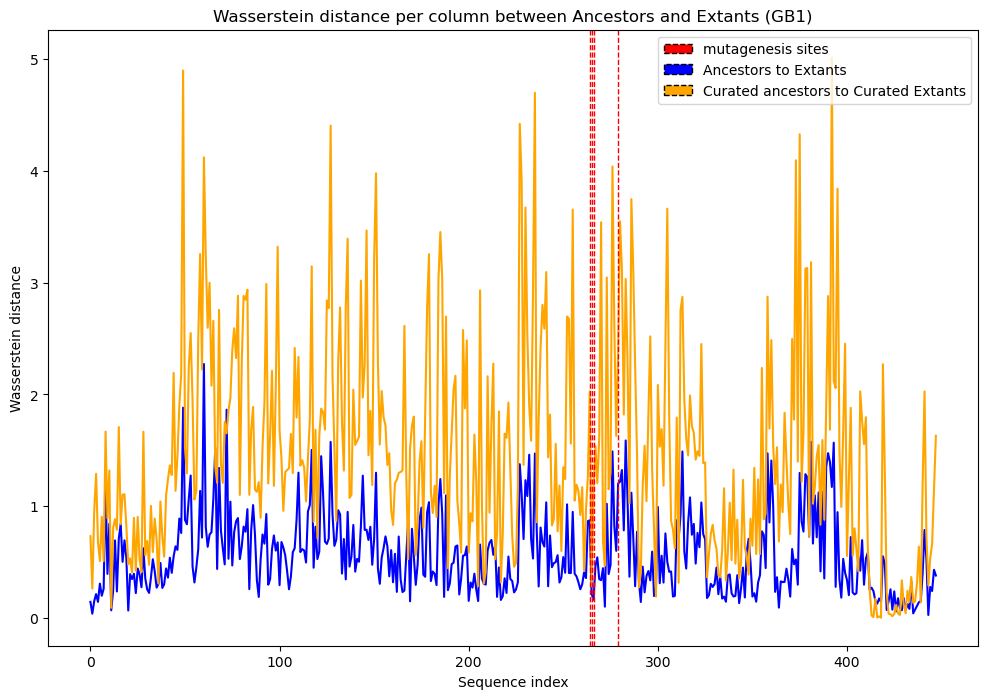

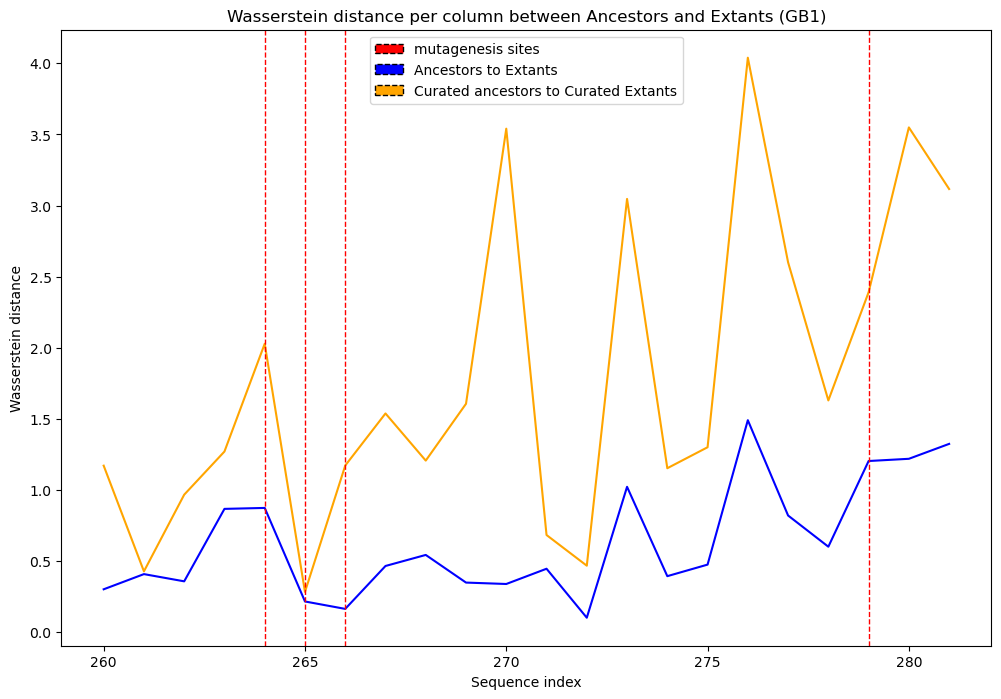

In [151]:
################ UNCURATED ##############
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks, wd_curated_a_to_curated_e, alpha=1, color='orange', label="Curated Ancestors- Curated Extants")
mutations = [264, 265, 266, 279]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (GB1)")
plt.show()


################### CURATED ANCESTORS & EXTANTS ##################
xticks = range(0, len(wd_curated_a_to_curated_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[260:282], wd_a_to_e[260:282], alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks[260:282], wd_curated_a_to_curated_e[260:282], alpha=1, color='orange', label="Curated ancestors-Extants")


mutations = [264, 265, 266, 279]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")

plt.title("Wasserstein distance per column between Ancestors and Extants (GB1)")
plt.show()

### GB1 - curated sequence weights distribtutions

In [152]:


aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_e = pd.read_pickle(aln_path + "gb1_extants_no_dupes.pkl")
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")
gb1_ae = pd.read_pickle(aln_path + "gb1_ancestors_extants_no_dupes.pkl")

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/"
curated_gb1_e = st.read_aln_file(aln_path + "gb1_0.32_sim_extants_no_dupes.aln")
curated_gb1_a = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_no_dupes.aln")
curated_gb1_ae = st.read_aln_file(aln_path + "gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln")

datasets = [gb1_e, gb1_a, gb1_ae, curated_gb1_e, curated_gb1_a, curated_gb1_ae]

for data in datasets:
    numpy_aln, _, _ = st.convert_msa_numpy_array(data)
    data["seq_sim"] = st.reweight_by_seq_similarity(numpy_aln, 0.2)
    data["col_sim"] = st.position_based_seq_weighting(numpy_aln, 4)


Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 455
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_0.32_sim_ancestors_0.32_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8655
Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (14276, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (455, 448)
Sequence weight numpy array created with shape (num_

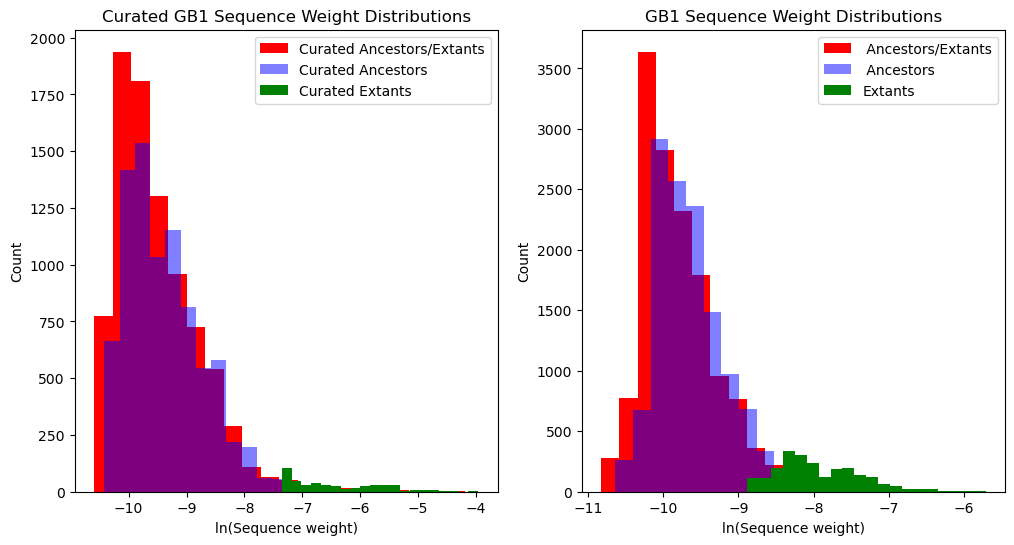

In [166]:

# plt.hist(curated_gb1_ae["col_sim"], color="red", alpha=1, bins=100, label="Curated Ancestors/Extants")
# plt.hist(curated_gb1_a["col_sim"], color="blue", alpha=0.5, bins=100, label="Curated Ancestors")
# plt.hist(curated_gb1_e["col_sim"], color="green", alpha=1, bins=100, label="Extants")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.hist(np.log(curated_gb1_ae["col_sim"]), color="red", alpha=1, bins=20, label="Curated Ancestors/Extants")
ax1.hist(np.log(curated_gb1_a["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated Ancestors")
ax1.hist(np.log(curated_gb1_e["col_sim"]), color="green", alpha=1, bins=20, label="Curated Extants")

ax1.set_ylabel("Count")
ax1.set_xlabel("ln(Sequence weight)")
ax1.set_title("Curated GB1 Sequence Weight Distributions")
ax1.legend()

ax2.hist(np.log(gb1_ae["col_sim"]), color="red", alpha=1, bins=20, label=" Ancestors/Extants")
ax2.hist(np.log(gb1_a["col_sim"]), color="blue", alpha=0.5, bins=20, label=" Ancestors")
ax2.hist(np.log(gb1_e["col_sim"]), color="green", alpha=1, bins=20, label="Extants")

ax2.set_ylabel("Count")
ax2.set_xlabel("ln(Sequence weight)")
ax2.set_title("GB1 Sequence Weight Distributions")
ax2.legend()

plt.show()


# GFP 

In [62]:
gfp_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,K3R:V55A:Q94R:A110T:D117G:M153K:D216A,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.301030,0
1,K3Q:V16A:I167T:L195Q,MSQGEELFTGVVPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.137350,1
2,K3Q:Y143C:N164D:S205P:A227T,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.553913,0
3,K3Q:Y143N:V193A,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.404237,1
4,K3R,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.738586,1


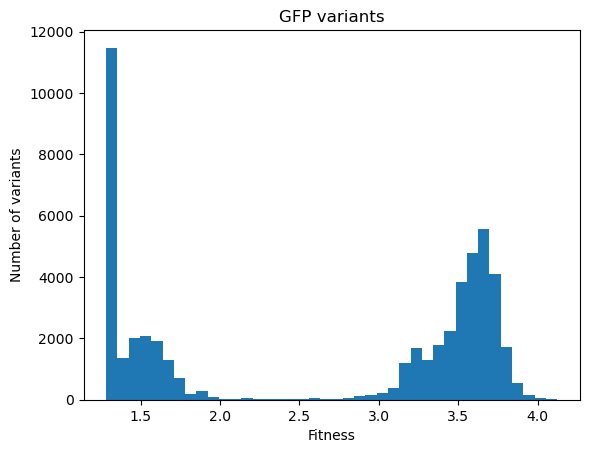

In [63]:
plt.hist(gfp_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GFP variants")
plt.show()

In [6]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/"
gfp_e = pd.read_pickle(aln_path + "gfp_extants_no_syn_no_dupes.pkl")
gfp_a = pd.read_pickle(aln_path + "gfp_ancestors_no_syn_no_dupes.pkl")

gfp_extant_seqs = [x for x in gfp_e["sequence"]]
gfp_ancestor_seqs = [x for x in gfp_a["sequence"]]

data = [gfp_extant_seqs, gfp_ancestor_seqs]
labels = ["GFP extant MSA", "GFP ancestor MSA"]

In [7]:
#convert to numpy form for quick processing
gfp_e_col_entropy = stats.calc_shannon_entropy(gfp_e) 
gfp_a_col_entropy = stats.calc_shannon_entropy(gfp_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)


In [143]:
gfp_muts = set()

for x in gfp_variants["mutant"]:
    data = x.split(":")
    for z in data:
        gfp_muts.add(z[1:-1])
print(len(gfp_muts))
print(min(gfp_muts), max(gfp_muts))

233
10 99


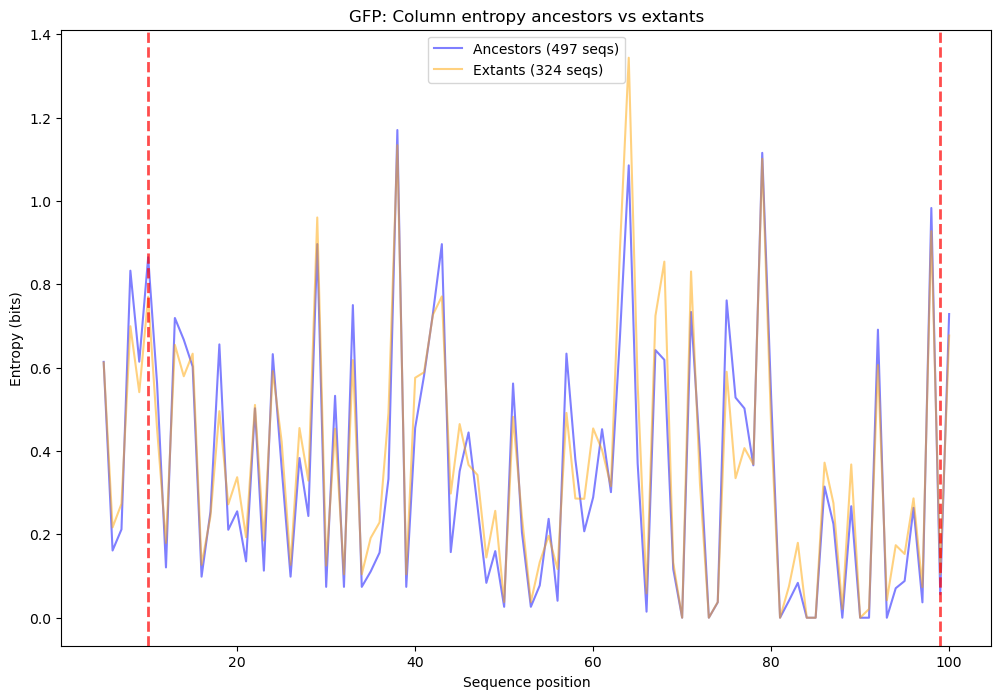

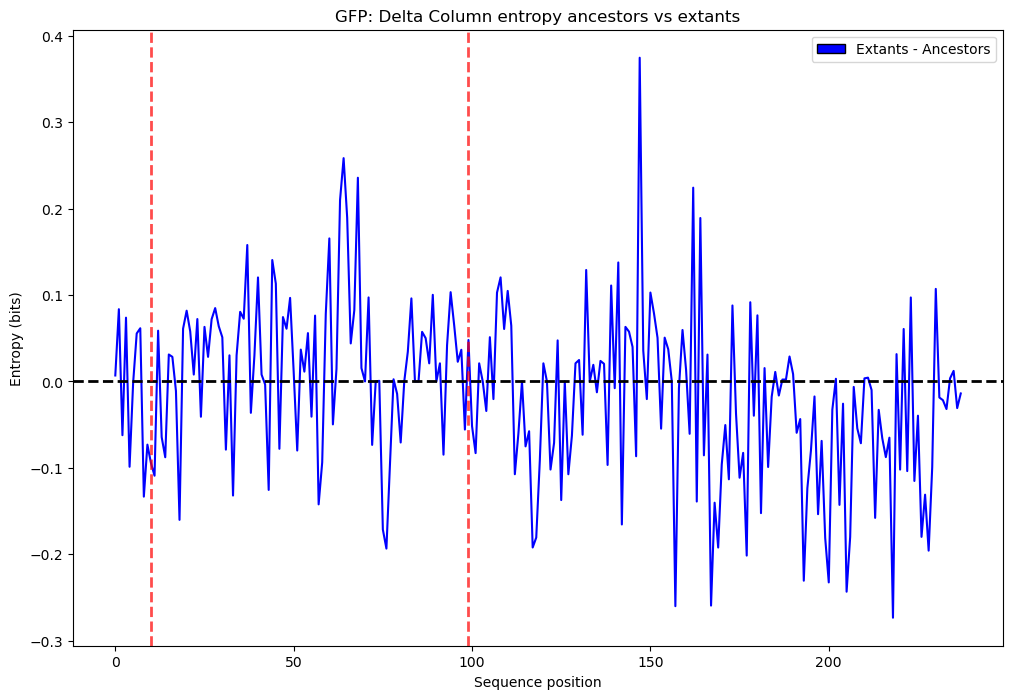

In [8]:

# across entire sequnece 
xticks = range(0, len(gfp_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[5:101], gfp_a_col_entropy[5:101], alpha=0.5, label="Ancestors (497 seqs)", color='blue')
plt.plot(xticks[5:101], gfp_e_col_entropy[5:101], alpha=0.5, label="Extants (324 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

mutations = [10, 99]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=2, alpha=0.7)

plt.legend()

plt.title("GFP: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across entire sequnece 
xticks = range(0, len(gfp_e_col_entropy))
delta_col_h = gfp_e_col_entropy - gfp_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=1, label="Delta entropy (Extants - Ancestors)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=2, alpha=0.7)


plt.legend(handles=legend_elements,)

plt.title("GFP: Delta Column entropy ancestors vs extants")
plt.show()





##### GFP - Wasserstein distance 

In [43]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/"
gfp_a = pd.read_pickle(path + "gfp_ancestors_no_syn_no_dupes.pkl")
gfp_ae = pd.read_pickle(path + "gfp_ancestors_extants_no_syn_no_dupes.pkl")
gfp_e = pd.read_pickle(path + "gfp_extants_no_syn_no_dupes.pkl")

In [45]:
gfp_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants = gfp_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

In [46]:
gfp_variants.head()

,id,sequence,DMS_score,DMS_score_bin
0,K3R:V55A:Q94R:A110T:D117G:M153K:D216A,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.301030,0
1,K3Q:V16A:I167T:L195Q,MSQGEELFTGVVPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.137350,1
2,K3Q:Y143C:N164D:S205P:A227T,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.553913,0
3,K3Q:Y143N:V193A,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.404237,1
4,K3R,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.738586,1


Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (673, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (51714, 238)
Dist A-E: 0.2759415972961954
Dist A-AE: 0.06325623399643425
Dist E-AE: 0.22453658421158343
Dist A-V: 0.9283286071308591
Dist E-V: 0.8032552909782081
Dist AE-V: 0.9213718999208078


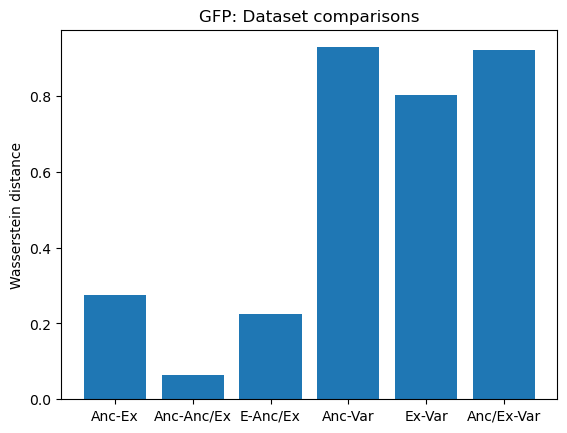

In [49]:
gfp_a_ppm = stats.calc_position_prob_matrix(gfp_a)
gfp_e_ppm = stats.calc_position_prob_matrix(gfp_e)
gfp_ae_ppm = stats.calc_position_prob_matrix(gfp_ae)
gfp_var_ppm = stats.calc_position_prob_matrix(gfp_variants)

wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_curated_e_to_v = []
wd_ae_to_v = []

for i in range(gfp_a_ppm.shape[1]):
    col_a_i = gfp_a_ppm[:, i]
    col_e_i = gfp_e_ppm[:, i]
    col_ae_i = gfp_ae_ppm[:, i]
    col_v_i = gfp_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_curated_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_ae_to_v)])
plt.title("GFP: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_small_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 8343
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gb1/profile_creation/alns/gb1_small_ancestors_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 10484
Sequence weight numpy array created with shape (num_seqs, columns):  (8343, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)


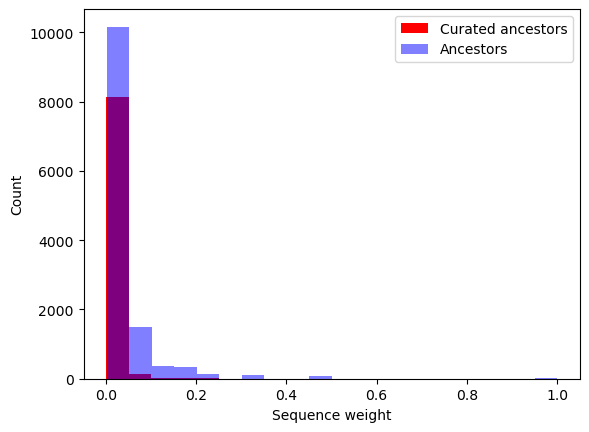

# A4 

In [76]:
#672-713 (673) /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns A4_HUMAN_Seuma_2022

a4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
a4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,A673C,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-1.018869,1
1,A673D,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.605052,1
2,A673E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.590857,1
3,A673E:A692E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-2.443601,0
4,A673E:A692T,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-3.049893,0


In [99]:
# all the mutation positoins will be here 
a4_muts = set()

for x in a4_variants["mutant"]:
    data = x.split(":")
    a = data[0][1:-1]
    a4_muts.add(a)
    if len(data) == 2:
        b = data[1][1:-1]
        a4_muts.add(b)
len(a4_muts)
print(min(a4_muts), max(a4_muts))

672 713


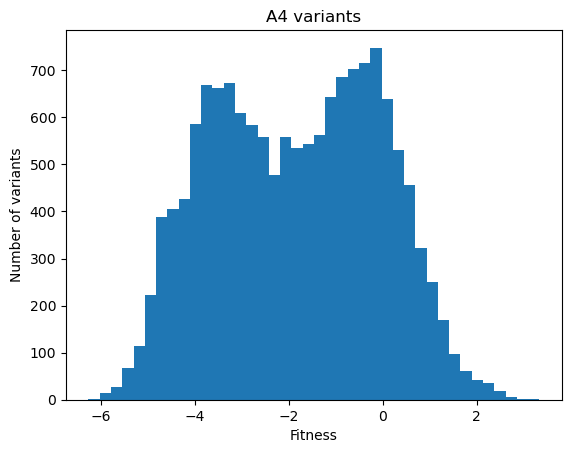

In [78]:
a4_variants["DMS_score"].describe()

plt.hist(a4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("A4 variants")
plt.show()

In [79]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_e = pd.read_pickle(aln_path + "a4_extants_no_dupes.pkl")
a4_a = pd.read_pickle(aln_path + "a4_ancestors_no_dupes.pkl")

a4_extant_seqs = [x for x in a4_e["sequence"]]
a4_ancestor_seqs = [x for x in a4_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["A4 extant MSA", "A4 ancestor MSA"]

In [80]:
#convert to numpy form for quick processing
a4_e_col_entropy = stats.calc_shannon_entropy(a4_e) 
a4_a_col_entropy = stats.calc_shannon_entropy(a4_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)


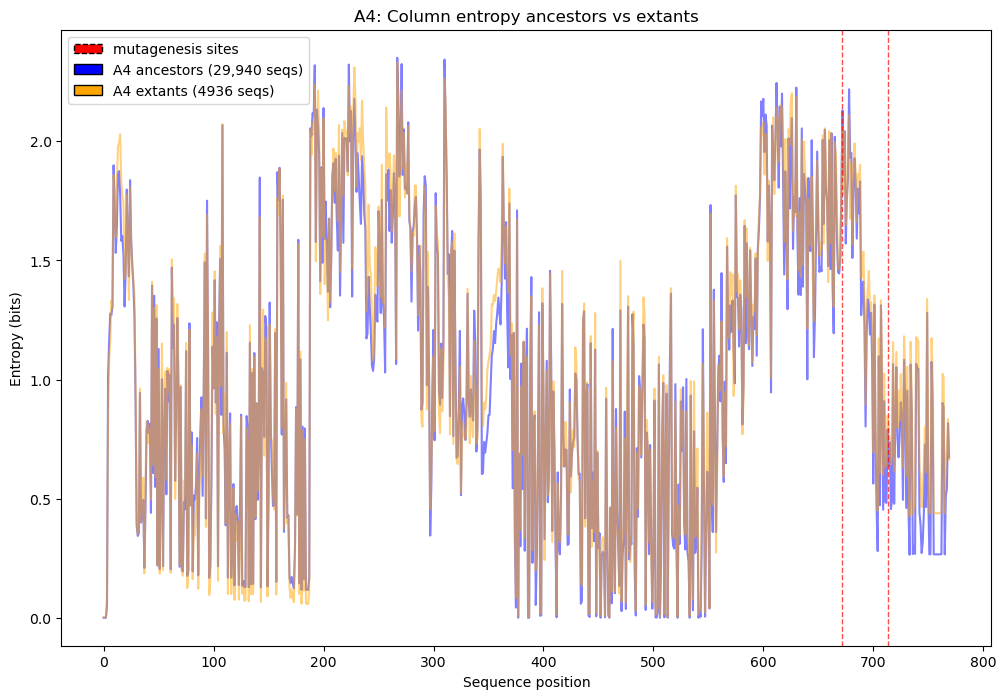

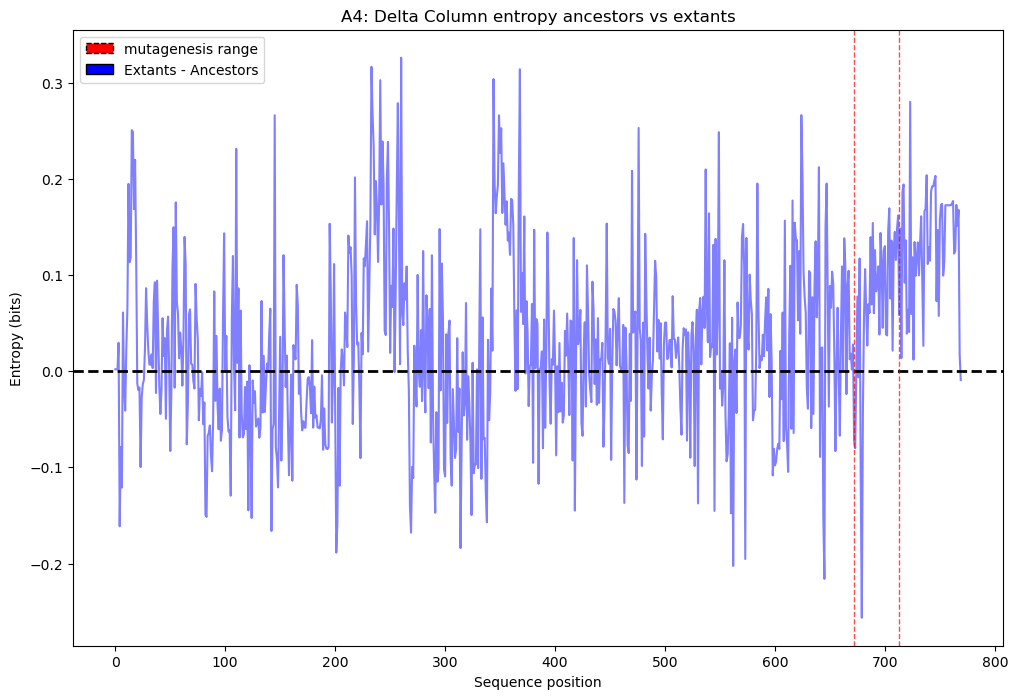

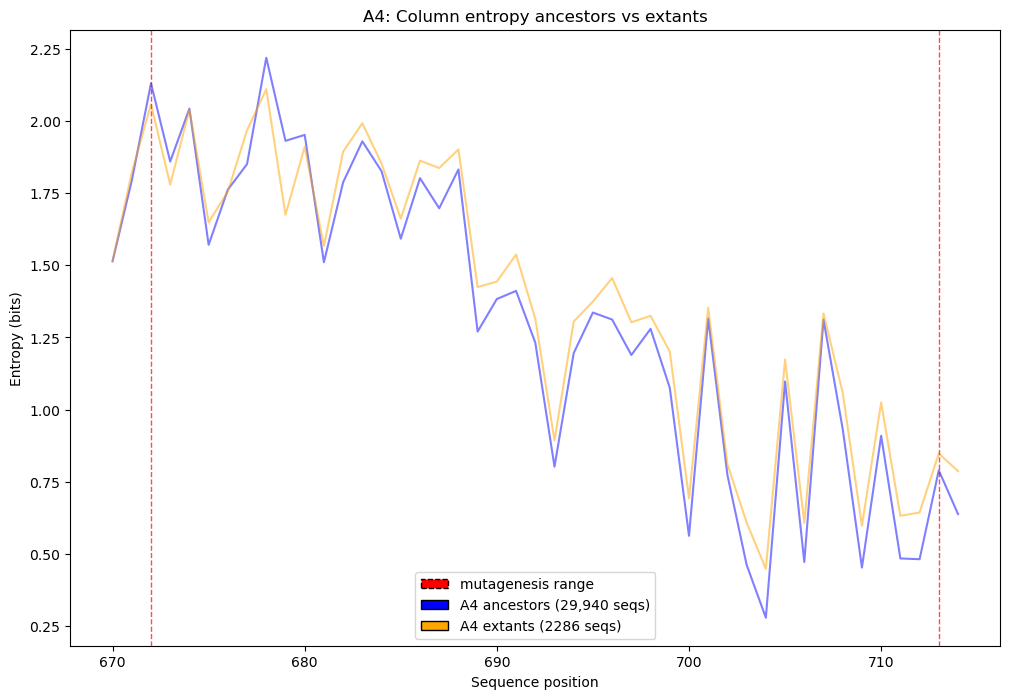

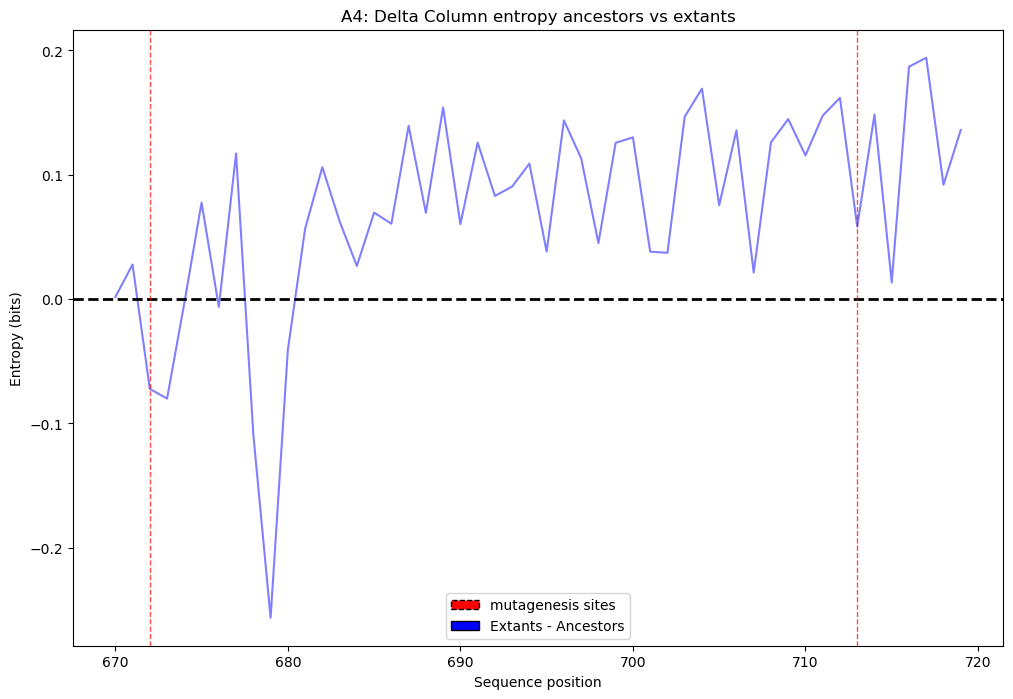

In [139]:

# across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy, alpha=0.5, label="A4 ancestors (29,940 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy, alpha=0.5, label="A4 extants (4936 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (4936 seqs)'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))
delta_col_h = a4_e_col_entropy - a4_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# now just across the mutation sites 
xticks = range(670, 715)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy[670:715], alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy[670:715], alpha=0.5, label="A4 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")



legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (2286 seqs)'),
]


#plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across subset of sequnece 
xticks = range(670, 720)
delta_col_h = (a4_e_col_entropy - a4_a_col_entropy)[670:720]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

#plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),

]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()



#### A4 - Wasserstein distance

In [51]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_a = pd.read_pickle(path + "a4_ancestors_no_dupes.pkl")
a4_ae = pd.read_pickle(path + "a4_ancestors_extants_no_dupes.pkl")
a4_e = pd.read_pickle(path + "a4_extants_no_dupes.pkl")

In [53]:
a4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
a4_variants = a4_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (32125, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (14811, 770)
Dist A-E: 0.4210166480071743
Dist A-AE: 0.030557751550906058
Dist E-AE: 0.3982470664809732
Dist A-V: 2.675403187327035
Dist E-V: 2.5448590168441774
Dist AE-V: 2.674009241245136


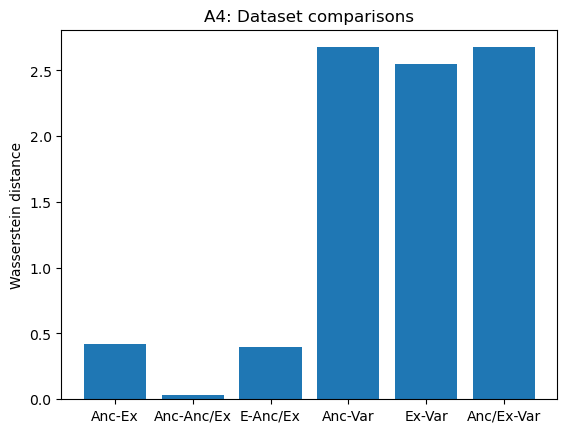

In [55]:
a4_a_ppm = stats.calc_position_prob_matrix(a4_a)
a4_e_ppm = stats.calc_position_prob_matrix(a4_e)
a4_ae_ppm = stats.calc_position_prob_matrix(a4_ae)
a4_var_ppm = stats.calc_position_prob_matrix(a4_variants)

wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_curated_e_to_v = []
wd_ae_to_v = []

for i in range(gb1_a_ppm.shape[1]):
    col_a_i = a4_a_ppm[:, i]
    col_e_i = a4_e_ppm[:, i]
    col_ae_i = a4_ae_ppm[:, i]
    col_v_i = a4_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_curated_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_ae_to_v)])
plt.title("A4: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()

# GCN4 

In [19]:
gcn4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")
gcn4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D103A,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.543932,1
1,D103A:F108N:K118D:S122Q:V135I:D139W,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.158042,0
2,D103A:S104T:T105I:P106T:M107L:F108T:E109S:N112...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.391235,1
3,D103A:S122A:V130Q:T132M:S144N,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.243840,0
4,D103A:S122E:S136P:K140S:A141R,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.678492,1


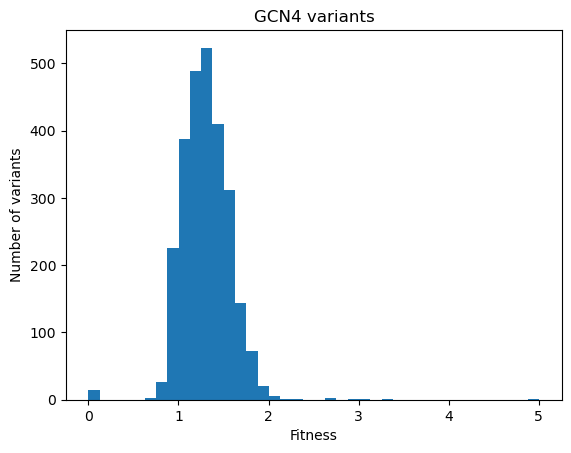

In [128]:
gcn4_variants["DMS_score"].describe()

plt.hist(gcn4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GCN4 variants")
plt.show()

### GCN4 - entropy 

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 283
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9171
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (283, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (9171, 281)


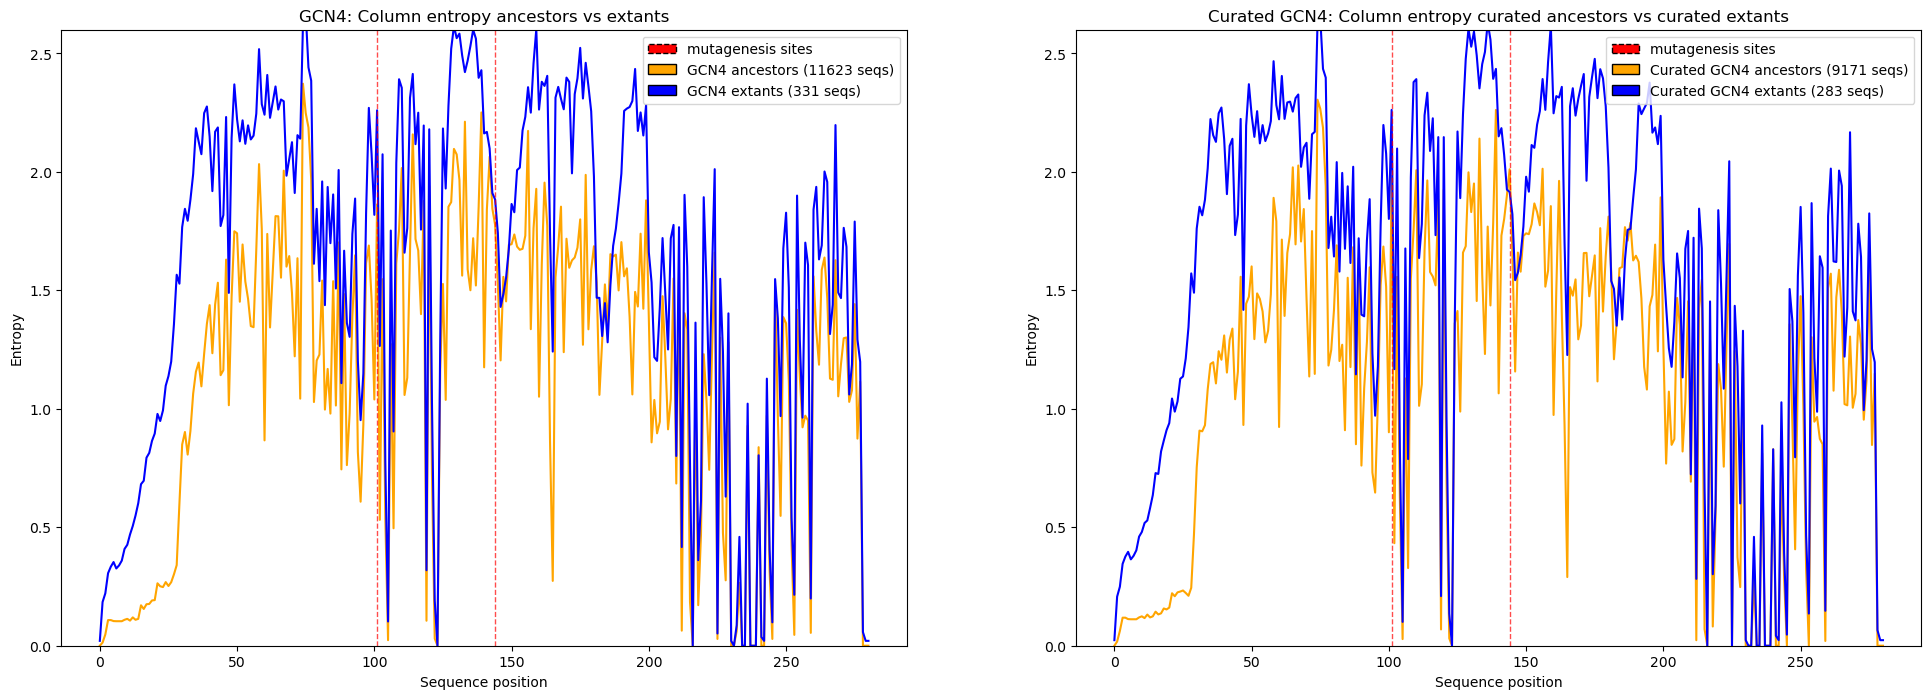

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (283, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (9171, 281)


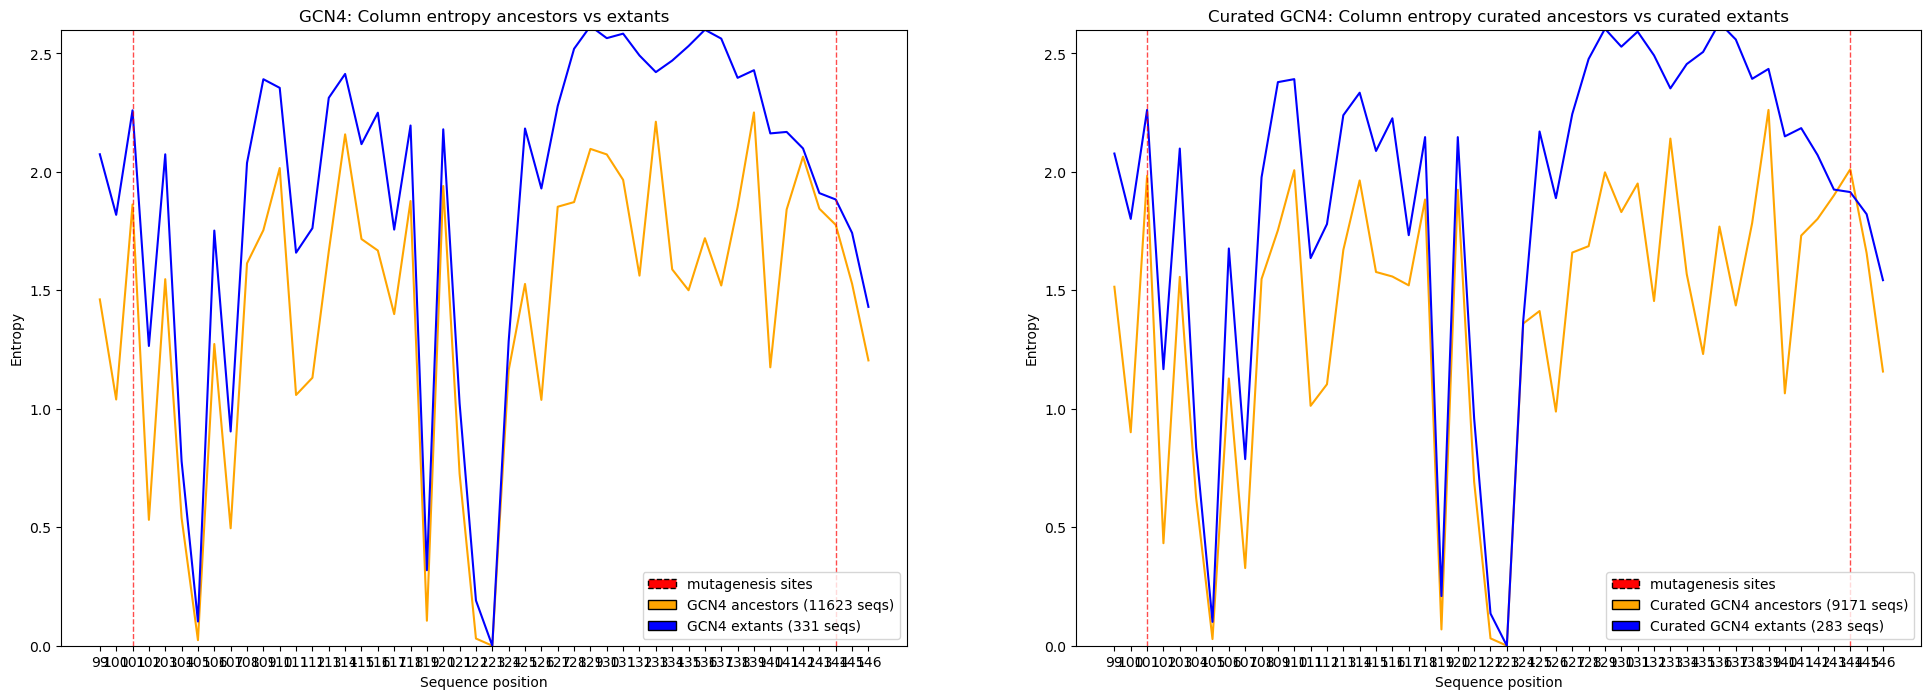

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [172]:
################ UNCURATED ##############

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_e = pd.read_pickle(aln_path + "gcn4_extants_no_dupes.pkl")
gcn4_a = pd.read_pickle(aln_path + "gcn4_ancestors_no_dupes.pkl")

################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/"
curated_gcn4_e = st.read_aln_file(aln_path + "gcn4_0.3_sim_extants_no_dupes.aln")
curated_gcn4_a = st.read_aln_file(aln_path + "gcn4_0.3_sim_ancestors_no_dupes.aln")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

plot_entropy(ancestors=gcn4_a, extants=gcn4_e, anc_count=11623, 
             ext_count=331, mutations = [101, 144], protein="GCN4", 
             title="Column entropy ancestors vs extants", ax=ax1)

plot_entropy(ancestors=curated_gcn4_a, extants=curated_gcn4_e, anc_count=9171, 
             ext_count=283, mutations = [101, 144], protein="Curated GCN4", 
             title="Column entropy curated ancestors vs curated extants", ax=ax2)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# do across a smaller range 
plot_entropy(ancestors=gcn4_a, extants=gcn4_e, anc_count=11623, 
             ext_count=331, mutations = [101, 144], protein="GCN4", 
             title="Column entropy ancestors vs extants", start=99, end=147, ax=ax1)


plot_entropy(ancestors=curated_gcn4_a, extants=curated_gcn4_e, anc_count=9171, 
             ext_count=283, mutations = [101, 144], protein="Curated GCN4", 
             title="Column entropy curated ancestors vs curated extants", start=99, end=147, ax=ax2)

plt.show()



##### GCN4 - Wasserstein distance

Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11904, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (2638, 281)
Dist A-E: 1.174627319740789
Dist A-AE: 0.027319806576114106
Dist E-AE: 1.147387000625605
Dist A-V: 4.484926744625584
Dist E-V: 4.533220287500702
Dist AE-V: 4.486078513005525
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9171
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9419
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim

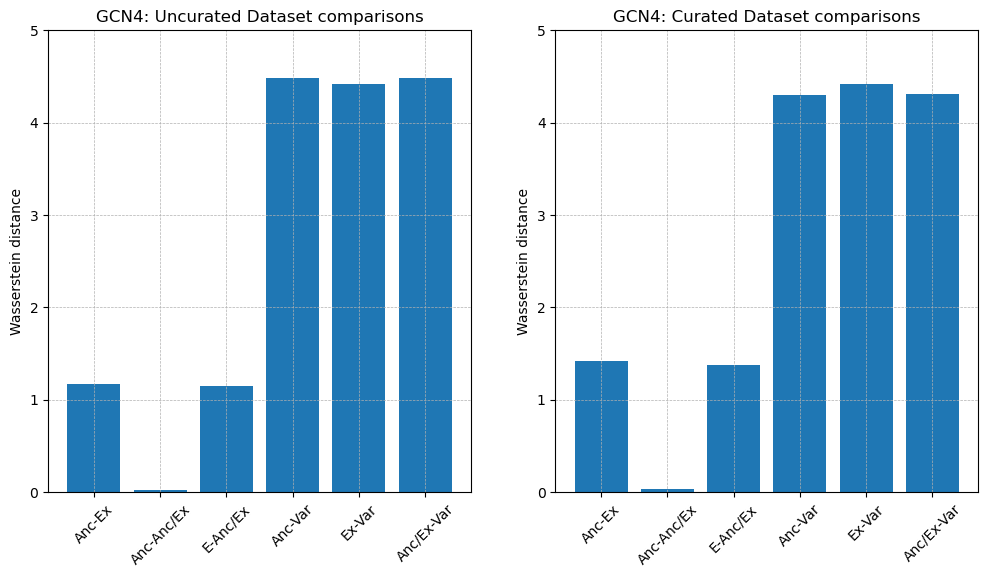

In [177]:


################ UNCURATED ##############
path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
wd_a_to_e, wd_a_to_ae, wd_e_to_ae, wd_a_to_v, wd_curated_e_to_v, wd_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gcn4_ancestors_no_dupes.pkl",
    extants= path + "gcn4_extants_no_dupes.pkl",
    ancestors_extants= path + "gcn4_ancestors_extants_no_dupes.pkl",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")


################### CURATED ANCESTORS & EXTANTS ##################

path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/"
wd_curated_a_to_curated_e, wd_curated_a_to_curated_ae, wd_curated_e_to_curated_ae, wd_curated_a_to_v, wd_curated_e_to_v, wd_curated_ae_to_v = calc_column_wasserstein_distances(
    ancestors= path + "gcn4_0.3_sim_ancestors_no_dupes.aln",
    extants= path + "gcn4_0.3_sim_extants_no_dupes.aln",
    ancestors_extants= path + "gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln",
    variants="/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")

print(f"Dist curated A-E: {np.mean(wd_curated_a_to_curated_e)}")
print(f"Dist curated A-AE: {np.mean(wd_curated_a_to_curated_ae)}")
print(f"Dist curated E-AE: {np.mean(wd_curated_e_to_curated_ae)}") 

print(f"Dist curated A-V: {np.mean(wd_curated_a_to_v)}")
print(f"Dist curated E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist curated AE-V: {np.mean(wd_curated_ae_to_v)}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_ae_to_v)])
ax1.set_title("GCN4: Uncurated Dataset comparisons")
ax1.set_ylabel("Wasserstein distance")
ax1.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax1.set_ylim(0,5)
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


ax2.bar(np.arange(6), [np.mean(wd_curated_a_to_curated_e), np.mean(wd_curated_a_to_curated_ae), np.mean(wd_curated_e_to_curated_ae), np.mean(wd_curated_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_curated_ae_to_v)])
ax2.set_title("GCN4: Curated Dataset comparisons")
ax2.set_ylabel("Wasserstein distance")
ax2.set_xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], rotation=45)
ax2.set_ylim(0,5)
ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)


plt.show()


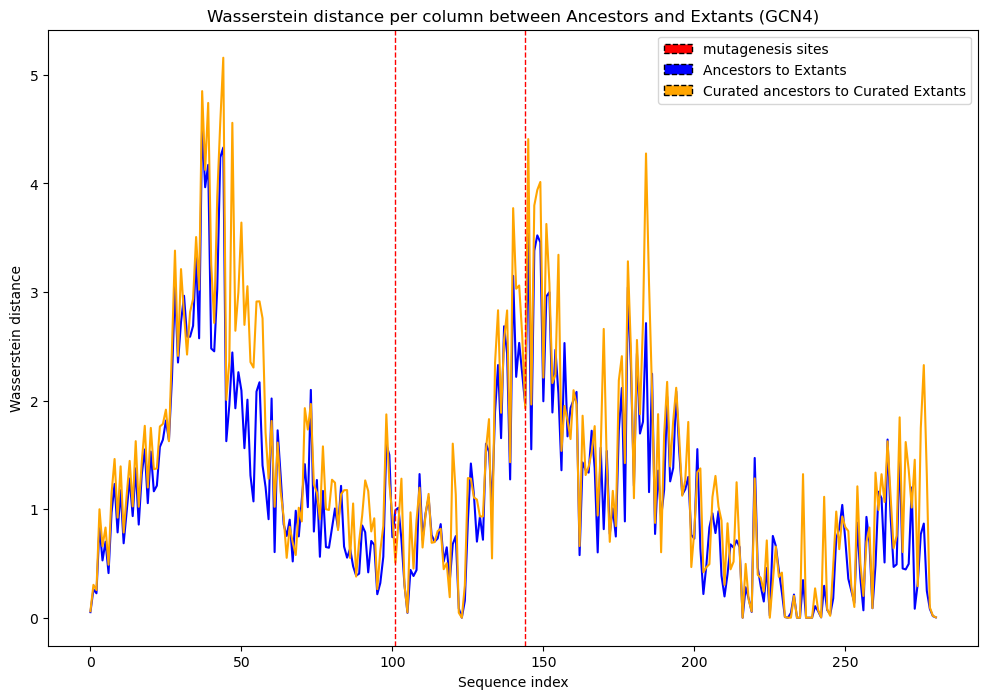

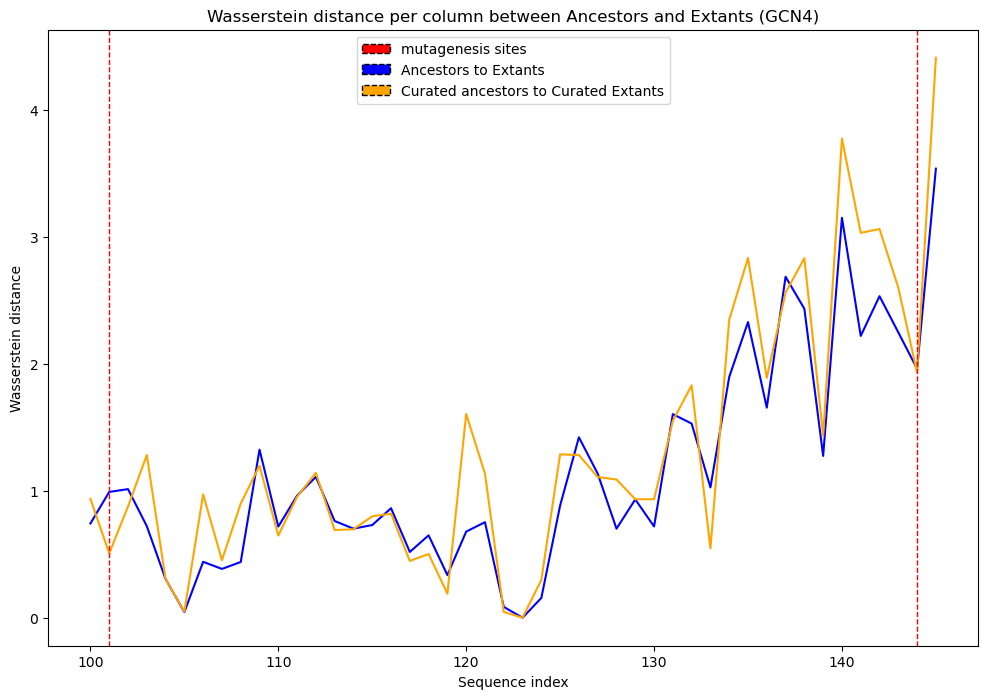

In [180]:
################ UNCURATED ##############
xticks = range(0, len(wd_a_to_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, wd_a_to_e, alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks, wd_curated_a_to_curated_e, alpha=1, color='orange', label="Curated Ancestors- Curated Extants")
mutations = [101, 144]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")
plt.title("Wasserstein distance per column between Ancestors and Extants (GCN4)")
plt.show()


################### CURATED ANCESTORS & EXTANTS ##################
xticks = range(0, len(wd_curated_a_to_curated_e))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks[100:146], wd_a_to_e[100:146], alpha=1, color='blue', label="Ancestors-Extants")
plt.plot(xticks[100:146], wd_curated_a_to_curated_e[100:146], alpha=1, color='orange', label="Curated ancestors-Extants")


mutations = [101, 144]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=1)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',linestyle='--', label='Ancestors to Extants '),
    Patch(facecolor='orange', edgecolor='black',linestyle='--', label='Curated ancestors to Curated Extants'),
]

plt.legend(handles=legend_elements,)
plt.ylabel("Wasserstein distance")
plt.xlabel("Sequence index")

plt.title("Wasserstein distance per column between Ancestors and Extants (GCN4)")
plt.show()

#### GCN4 - curated sequence weights distributions 

In [181]:

################ UNCURATED ##############

aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_e = pd.read_pickle(aln_path + "gcn4_extants_no_dupes.pkl")
gcn4_a = pd.read_pickle(aln_path + "gcn4_ancestors_no_dupes.pkl")
gcn4_ae = pd.read_pickle(aln_path + "gcn4_ancestors_extants_no_dupes.pkl")

################### CURATED ANCESTORS & EXTANTS ##################
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/"
curated_gcn4_e = st.read_aln_file(aln_path + "gcn4_0.3_sim_extants_no_dupes.aln")
curated_gcn4_a = st.read_aln_file(aln_path + "gcn4_0.3_sim_ancestors_no_dupes.aln")
curated_gcn4_ae = st.read_aln_file(aln_path + "gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln")

datasets = [gcn4_e, gcn4_a, gcn4_ae, curated_gcn4_e, curated_gcn4_a, curated_gcn4_ae]

for data in datasets:
    numpy_aln, _, _ = st.convert_msa_numpy_array(data)
    data["seq_sim"] = st.reweight_by_seq_similarity(numpy_aln, 0.2)
    data["col_sim"] = st.position_based_seq_weighting(numpy_aln, 4)

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 283
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9171
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/gcn4/curated/alns/gcn4_0.3_sim_ancestors_0.3_sim_extants_no_dupes.aln
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 9419
Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11904, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (283, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (9171, 28

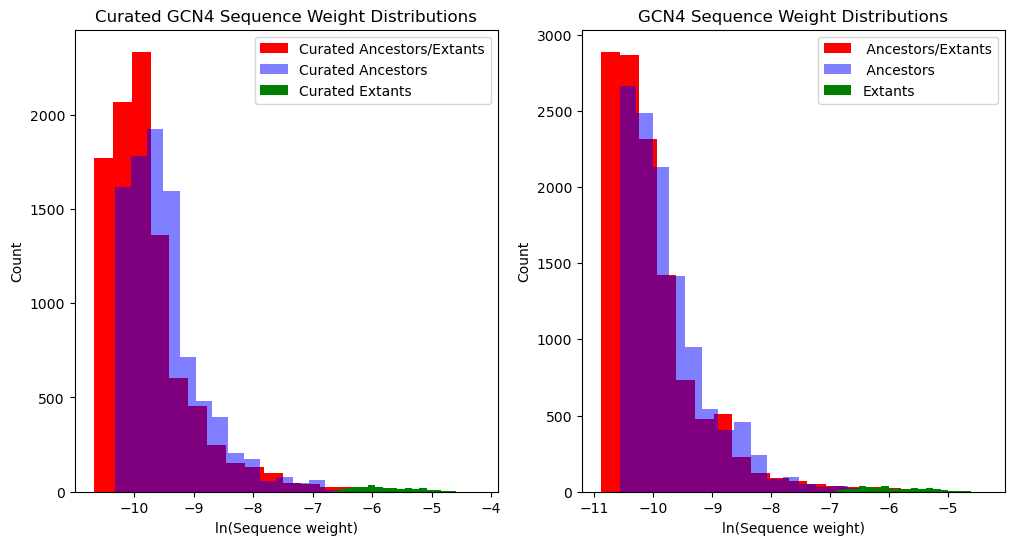

In [183]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.hist(np.log(curated_gcn4_ae["col_sim"]), color="red", alpha=1, bins=20, label="Curated Ancestors/Extants")
ax1.hist(np.log(curated_gcn4_a["col_sim"]), color="blue", alpha=0.5, bins=20, label="Curated Ancestors")
ax1.hist(np.log(curated_gcn4_e["col_sim"]), color="green", alpha=1, bins=20, label="Curated Extants")

ax1.set_ylabel("Count")
ax1.set_xlabel("ln(Sequence weight)")
ax1.set_title("Curated GCN4 Sequence Weight Distributions")
ax1.legend()

ax2.hist(np.log(gcn4_ae["col_sim"]), color="red", alpha=1, bins=20, label=" Ancestors/Extants")
ax2.hist(np.log(gcn4_a["col_sim"]), color="blue", alpha=0.5, bins=20, label=" Ancestors")
ax2.hist(np.log(gcn4_e["col_sim"]), color="green", alpha=1, bins=20, label="Extants")

ax2.set_ylabel("Count")
ax2.set_xlabel("ln(Sequence weight)")
ax2.set_title("GCN4 Sequence Weight Distributions")
ax2.legend()

plt.show()

# MAFG 

In [11]:
mafg_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/MAFG_MOUSE_Tsuboyama_2023_1K1V.csv")
mafg_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D3A,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQRRRTLKNRGY,-1.274690,0
1,D3A:R32A,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQARRTLKNRGY,-1.637233,0
2,D3A:R32C,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQCRRTLKNRGY,-1.081258,0
3,D3A:R32D,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQDRRTLKNRGY,-1.938164,0
4,D3A:R32E,LTAEELVTMSVRELNQHLRGLSKEEIIQLKQERRTLKNRGY,-1.893906,0


In [22]:
# all the mutation positoins will be here 
mafg_muts = set()

for x in mafg_variants["mutant"]:
    data = x.split(":")
    for z in data:
        b = z[1:-1]
        mafg_muts.add(int(b))

print(len(mafg_muts))
print(min(mafg_muts), max(mafg_muts))

41
1 41


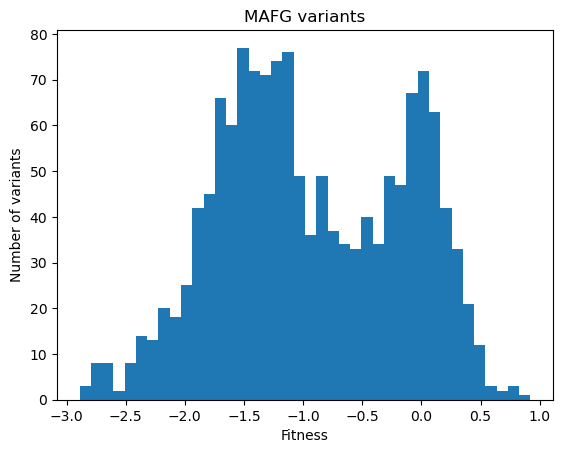

In [24]:
mafg_variants["DMS_score"].describe()

plt.hist(mafg_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("MAFG variants")
plt.show()

In [30]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/"
gcn4_e = st.read_aln_file(aln_path + "mafg_extants_no_dupes.fasta")
gcn4_a = st.read_aln_file(aln_path + "mafg_ancestors_no_dupes.fasta")



Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 962
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 3682


In [31]:
#convert to numpy form for quick processing
gcn4_e_col_entropy = stats.calc_shannon_entropy(gcn4_e) 
gcn4_a_col_entropy = stats.calc_shannon_entropy(gcn4_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (962, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (3682, 41)


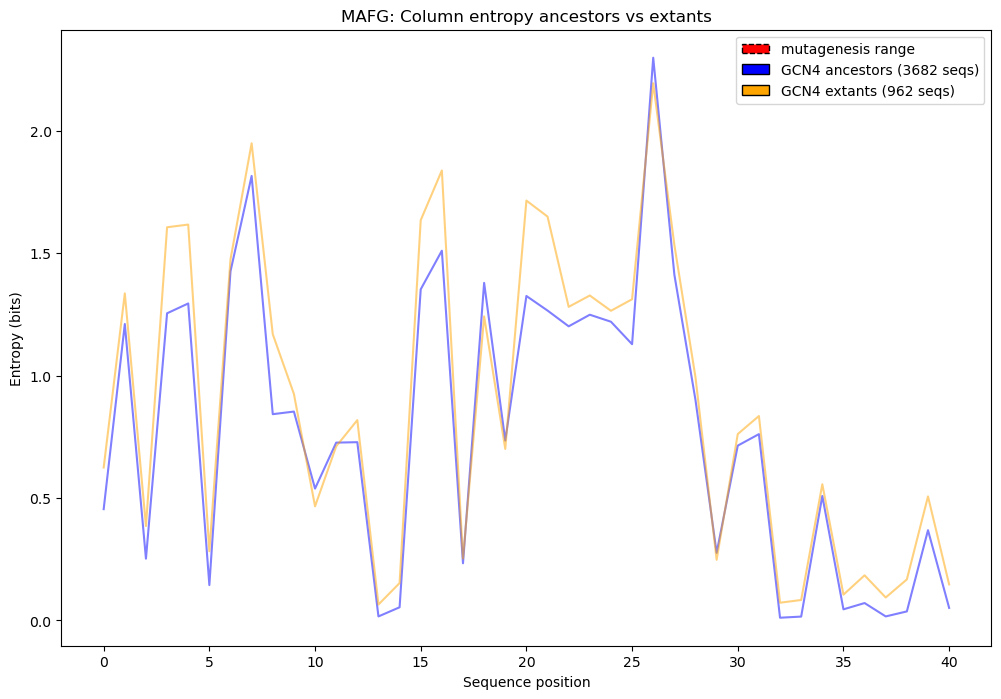

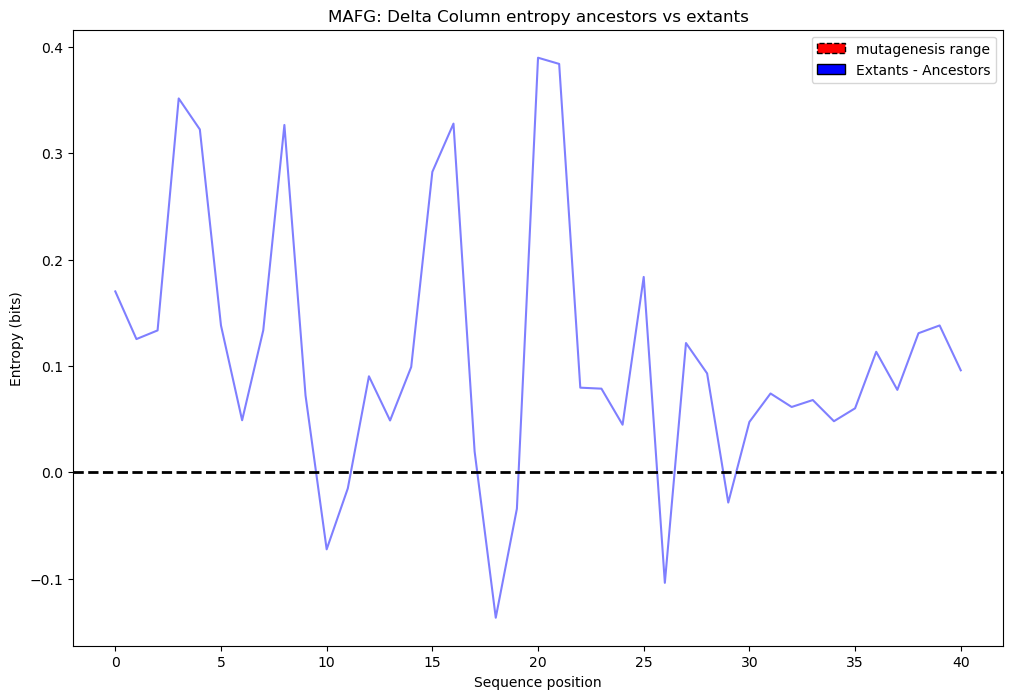

ValueError: x and y must have same first dimension, but have shapes (48,) and (0,)

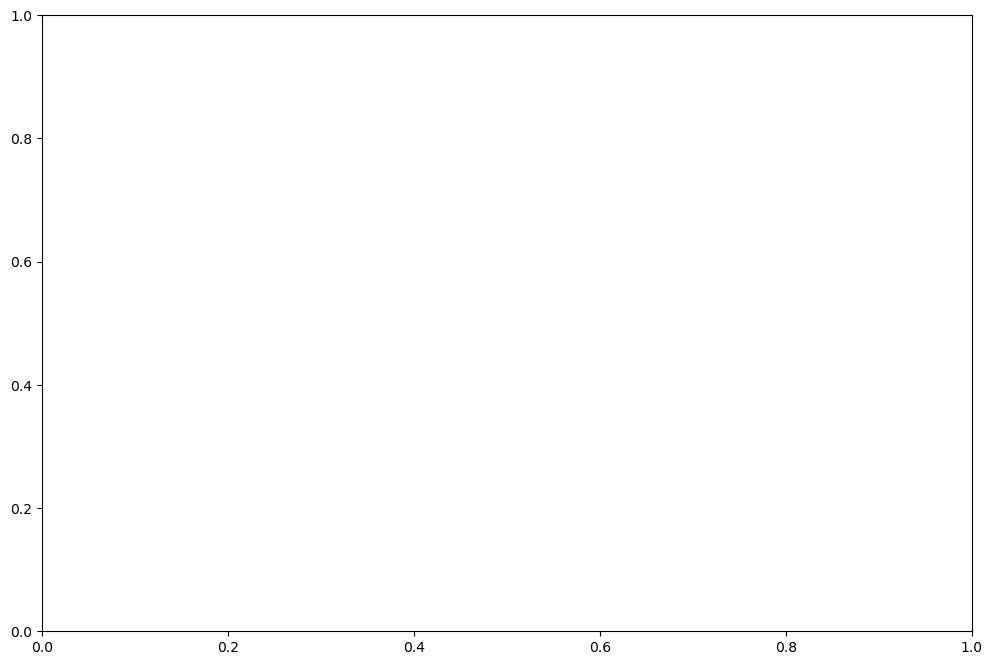

In [33]:

# across entire sequnece 
xticks = range(0, len(gcn4_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gcn4_a_col_entropy, alpha=0.5, color='blue')
plt.plot(xticks, gcn4_e_col_entropy, alpha=0.5, color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='GCN4 ancestors (3682 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='GCN4 extants (962 seqs)'),
]

plt.legend(handles=legend_elements,)


plt.title("MAFG: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across entire sequnece 
xticks = range(0, len(gcn4_e_col_entropy))
delta_col_h = gcn4_e_col_entropy - gcn4_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)



plt.title("MAFG: Delta Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# now just across the mutation sites 
xticks = range(99, 147)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gcn4_a_col_entropy[99:147], alpha=0.5, label="GCN4 ancestors (x seqs)", color='blue')
plt.plot(xticks, gcn4_e_col_entropy[99:147], alpha=0.5, label="GCN4 extants (x seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy (bits)")


legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='MAFG ancestors (x seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='MAFG extants (x seqs)'),
]

#plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("MAFG: Column entropy ancestors vs extants")
plt.show()



### MAFG - Wasserstein Distance

In [37]:
path = "/Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/"
gcn4_a = st.read_aln_file(path + "mafg_ancestors_no_dupes.fasta")
gcn4_ae = st.read_aln_file(path + "mafg_ancestors_extants_no_dupes.fasta")
gcn4_e = st.read_aln_file(path + "mafg_extants_no_dupes.fasta")

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 3682
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_ancestors_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 3965
Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/mafg_mouse/alns/mafg_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 962


In [38]:
gcn4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/MAFG_MOUSE_Tsuboyama_2023_1K1V.csv")
gcn4_variants = gcn4_variants.rename(columns={"mutated_sequence": "sequence", "mutant": "id"})

Sequence weight numpy array created with shape (num_seqs, columns):  (3682, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (962, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (3965, 41)
Sequence weight numpy array created with shape (num_seqs, columns):  (1429, 41)
Dist A-E: 0.4310420149240516
Dist A-AE: 0.03613274449548296
Dist E-AE: 0.39826530926091114
Dist A-V: 1.6079479318589653
Dist E-V: 1.530040566958759
Dist AE-V: 1.6127943654857588


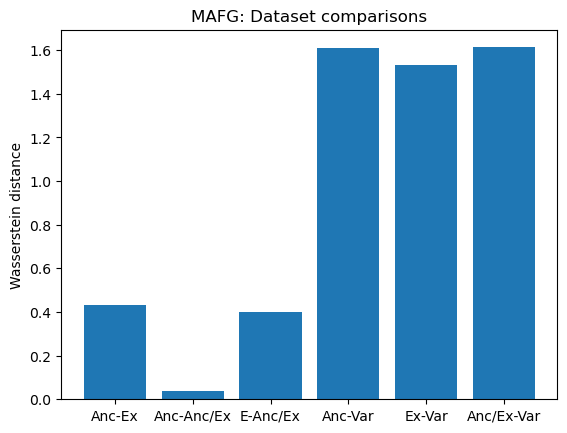

In [39]:
gcn4_a_ppm = stats.calc_position_prob_matrix(gcn4_a)
gcn4_e_ppm = stats.calc_position_prob_matrix(gcn4_e)
gcn4_ae_ppm = stats.calc_position_prob_matrix(gcn4_ae)
gcn4_var_ppm = stats.calc_position_prob_matrix(gcn4_variants)

wd_a_to_e = []
wd_a_to_ae = []
wd_e_to_ae = []
wd_a_to_v = []
wd_curated_e_to_v = []
wd_ae_to_v = []

for i in range(gcn4_a_ppm.shape[1]):
    col_a_i = gcn4_a_ppm[:, i]
    col_e_i = gcn4_e_ppm[:, i]
    col_ae_i = gcn4_ae_ppm[:, i]
    col_v_i = gcn4_var_ppm[:, i]
    
    wd_a_to_e.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)),col_a_i, col_e_i))
    wd_a_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_a_i, col_ae_i))
    wd_e_to_ae.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_ae_i))

    wd_a_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_a_i)), col_a_i, col_v_i))
    wd_curated_e_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_e_i, col_v_i)) 
    wd_ae_to_v.append(wasserstein_distance(np.arange(len(col_a_i)), np.arange(len(col_ae_i)), col_ae_i, col_v_i))

print(f"Dist A-E: {np.mean(wd_a_to_e)}")
print(f"Dist A-AE: {np.mean(wd_a_to_ae)}")
print(f"Dist E-AE: {np.mean(wd_e_to_ae)}")

print(f"Dist A-V: {np.mean(wd_a_to_v)}")
print(f"Dist E-V: {np.mean(wd_curated_e_to_v)}")
print(f"Dist AE-V: {np.mean(wd_ae_to_v)}")

plt.bar(np.arange(6), [np.mean(wd_a_to_e), np.mean(wd_a_to_ae), np.mean(wd_e_to_ae), np.mean(wd_a_to_v), np.mean(wd_curated_e_to_v), np.mean(wd_ae_to_v)])
plt.title("MAFG: Dataset comparisons")
plt.ylabel("Wasserstein distance")
plt.xticks(ticks=np.arange(6), labels=["Anc-Ex", "Anc-Anc/Ex", "E-Anc/Ex", "Anc-Var", "Ex-Var", "Anc/Ex-Var"], )
plt.show()